<a href="https://colab.research.google.com/github/giacomobinco/FDS-Final-Project/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# Loading all the necessary libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import zipfile
import os
from tqdm import tqdm
import shutil
import gc

import random
import warnings

from google.colab import files
from google.colab import drive

from sklearn.model_selection import StratifiedShuffleSplit, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from torch.nn.functional import softmax
import torchvision.models as models # to retrivie the "EfficientNet" models' family
from torch.optim.lr_scheduler import CosineAnnealingLR

In [2]:
# Checking if the GPU is selected as hardware accelerator
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
Tesla T4


In [3]:
# Setting the seed for reproducibility (defining an utily function and executing it)

def set_seed(seed: int):

    # Python
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Setting a deterministic behaviour
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Setting the reproducibility of the "DataLoader" objects
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)

In [4]:
# Connecting Google Drive to the present notebook
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load all the Mel-spectograms (saved in Google Drive) generated from the "fma_small" dataset

# Retrieving the folder's path
drive_folder = "/content/drive/MyDrive/fma_spectrograms"

# Generating the output folder
output_directory = "fma_spectrograms_organized"
os.makedirs(output_directory, exist_ok=True)

# Copying all the images (files .png) in the output folder
for root, dirs, files in os.walk(drive_folder):
    for file in files:
        if file.lower().endswith(".png"):
            src_path = os.path.join(root, file)
            dst_path = os.path.join(output_directory, file)
            shutil.copy(src_path, dst_path)

In [6]:
# Load the metadata (saved in Google Drive) on the audio tracks

tracks = pd.read_csv(r"/content/drive/MyDrive/tracks.csv", index_col = 0, header = [0,1])

In [7]:
# "fma_spectrograms_organized" (assigned to the variable "output_directory") is the folder created in the previous part of code,
# as the name suggests, to save and organize all the spectrograms; whereas the final dataset will be saved in the following folder:
dataset_directory = "dataset"
os.makedirs(dataset_directory, exist_ok = True)

# Counters
copied = 0
skipped = 0

# For every file (spectrogram) saved in "output_directory" ...
for fname in os.listdir(output_directory):

    # ... consider only the .png files (there shouldn't be any others though)
    if not fname.lower().endswith(".png"):
        continue

    # Get the audio track ID from the file name (according to the method used to generate the spectrograms in the first place)
    track_id_str = fname.split("_")[0]

    # Convert the file name (a sequence of numbers) in a "int" object
    try:
        track_id = int(track_id_str)

    # If the conversion fails, the file is skipped
    except:
        skipped += 1
        continue

    # If the audio track ID doesn't exist in the audio tracks dataset (file "tracks.csv"), the file is skipped
    if track_id not in tracks.index:
        skipped += 1
        continue

    # From said dataset, collect the audio track's main genre
    genre = tracks.loc[track_id, ('track','genre_top')]

    # Create the genre folder (see next the structure that the dataset should have)
    genre_directory = os.path.join(dataset_directory, genre)
    os.makedirs(genre_directory, exist_ok = True)

    # Copy the spectrogram in the corresponding genre folder
    shutil.copy(os.path.join(output_directory, fname), os.path.join(genre_directory, fname))
    copied += 1

# Visual check
print(f"✅ {copied} files has been copied in the genres' sub-folders")
if skipped > 0:
  print(f"\n⚠️ {skipped} files with no correspondece has been found")

✅ 7997 files has been copied in the genres' sub-folders


In [8]:
# To remove a directory (a specific ones in this case):

!rm -rf sample_data/

In [9]:
# Using the current structure of the dataset (organized in sub-folders per genre), two sets are defined
# - The training test will be used to train the model, evaluate each execution and consequently update it
# - The test set will be used to compute the final evaluation of the model
# Since the dataset is almost perfectly balanced, the same structure is kept in both the training and the test sets
# --> considering 8000 images (1000 per genre), the training set contains 80% of them (6400 images, 800 per genre),
#     while the test set has the remaing 20% (1600 images, 200 per genre)

# Output directories, aka where the images will be copied from "dataset"
# (The dataset directory has been created in the previous cell)
TRAIN_DIRECTORY = "/content/dataset_train"
TEST_DIRECTORY  = "/content/dataset_test"
os.makedirs(TRAIN_DIRECTORY, exist_ok = True)
os.makedirs(TEST_DIRECTORY, exist_ok = True)

# 1. Loading the images (spectrograms) and the labels (genres)

file_paths = [] # it will contain all the images
labels = []     # it will contain the corresponding labels

genres = sorted(os.listdir(dataset_directory))

for genre in genres:

    genre_dir = os.path.join(dataset_directory, genre)
    images = os.listdir(genre_dir) # all the images contained in a specific genre sub-folder (the one of the currente iteration)

    for img in images:

        file_paths.append(os.path.join(genre_dir, img)) # add the image to the container
        labels.append(genre)                            # add the corresponding genre to the container

file_paths = np.array(file_paths)
labels = np.array(labels)

# 2. Creating the split with "StratifiedShuffleSplit()", which automatically keeps the dataset balanced

splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.20, random_state = 42)

for train_idx, test_idx in splitter.split(file_paths, labels):

    train_files = file_paths[train_idx] # spectrograms of the trainig set
    train_labels = labels[train_idx]    # genres of these spectrograms (training)
    test_files  = file_paths[test_idx]  # spectrograms of the test set
    test_labels = labels[test_idx]      # genres of these spectrograms (test)

# 3. Copying the files in the corresponding folders (created at the beginning of this cell)

def copy_files(files, labels, destination_root):
    # Utility function to use to execute this last task
    for file, label in zip(files, labels):
        dest_dir = os.path.join(destination_root, label) # selecting the correct folder
        os.makedirs(dest_dir, exist_ok = True)           # checking it exits
        shutil.copy(file, dest_dir)                      # copying the image

copy_files(train_files, train_labels, TRAIN_DIRECTORY)
copy_files(test_files, test_labels, TEST_DIRECTORY)

In [10]:
# @title
# Ignoring the normalization temporarily in order to compute the mean and standard deviation of the training dataset

transform_no_norm = transforms.Compose([
    transforms.ToTensor()])

dataset_no_norm = datasets.ImageFolder(TRAIN_DIRECTORY, transform = transform_no_norm)

loader = DataLoader(dataset_no_norm, batch_size = 64, shuffle = False, num_workers = 2)

train_mean = 0.0
train_std = 0.0
train_total_images = 0

for images, _ in loader:
    # Structure of the images' shape: (batch, channels, H, W)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)
    train_total_images += batch_samples

train_mean /= train_total_images
train_std /= train_total_images

print("Training set\n")
print("Mean per channel =", train_mean)
print("Standard Deviation per channel =", train_std)

Training set

Mean per channel = tensor([0.6550, 0.2474, 0.2826])
Standard Deviation per channel = tensor([0.2268, 0.1691, 0.1224])


In [11]:
# @title
# Ignoring the normalization temporarily in order to compute the mean and standard deviation of the test dataset

transform_no_norm = transforms.Compose([
    transforms.ToTensor()])

dataset_no_norm = datasets.ImageFolder(TEST_DIRECTORY, transform = transform_no_norm)

loader = DataLoader(dataset_no_norm, batch_size = 64, shuffle = False, num_workers = 2)

test_mean = 0.0
test_std = 0.0
test_total_images = 0

for images, _ in loader:
    # Structure of the images' shape: (batch, channels, H, W)
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)

    test_mean += images.mean(2).sum(0)
    test_std += images.std(2).sum(0)
    test_total_images += batch_samples

test_mean /= test_total_images
test_std /= test_total_images

print("Test set\n")
print("Mean per channel =", test_mean)
print("Standard Deviation per channel =", test_std)

Test set

Mean per channel = tensor([0.6518, 0.2448, 0.2847])
Standard Deviation per channel = tensor([0.2284, 0.1694, 0.1222])


In [12]:
# Creating a dataset of images for PyTorch, and loading it in a DataLoader object

training_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # spectrograms can be horizontally flipped
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(test_mean, test_std)])

train_dataset = datasets.ImageFolder(TRAIN_DIRECTORY, transform = training_transform)
test_dataset = datasets.ImageFolder(TEST_DIRECTORY, transform = test_transform)

# Check if everything went good
print("Training set ------------------------------")
print("\nNumber of categories found:", len(train_dataset.classes)) # they should be 8
print("Total number of images uploaded:", len(train_dataset))      # they should be 6397
print("\nTest set ----------------------------------")
print("\nNumber of categories found:", len(test_dataset.classes)) # they should be 8
print("Total number of images uploaded:", len(test_dataset))      # they should be 1600

Training set ------------------------------

Number of categories found: 8
Total number of images uploaded: 6397

Test set ----------------------------------

Number of categories found: 8
Total number of images uploaded: 1600


In [13]:
# Define a function that computes the necessary metrics to evaluate the model

def model_metrics(model, dataloader, device, loss_criterion, num_classes, top_k = 3):

  # The function accepts as input:
  # - the model (CNN) for which it will compute the metrics
  # - a datset of the "DataLoader" type to use for the computation
  # - a "torch.device" object (see the previous cell)
  # - the number of categories
  # - the value of k for the Top-k Accuracy (see the following code)

  model.eval() # set the model in modality "evaluation"

  # ------------------------------
  # 1. Saving labels, predictions, vectors of probabilities and loss values
  # ------------------------------

  valid_loss = 0.0

  all_labels = []        # it will contain the true values (labels indeed)
  all_predictions = []   # it will contain all the predictions
  all_probabilities = [] # it will contain the vector of probabilities for every image

  with torch.no_grad(): # block the tracking of the gradients (they're not needed during the evaluation phase)

    for X, y in dataloader: # "X" is a tensor containing the features, while "y" contains the labels (targets)

      X, y = X.to(device), y.to(device) # to accelerate the computation

      outputs = model(X)                        # For every image, generate the scores for every class, but ...
      predictions = outputs.argmax(dim = 1)     # ... save only the top-score (the prediction)
      probabilities = softmax(outputs, dim = 1) # Save the probabilities of belonging to every class for every image

      loss = loss_criterion(outputs, y)               # Computing the validation loss of the current epoch, ...
      valid_loss += loss.item()                       # ... saving said value ...
      valid_loss_epoch = valid_loss / len(dataloader) # ... and computing the mean value for the epoch

      # Adding the labels, predictions and probabilities to the corresponding containers ...
      all_labels.extend(y.cpu().numpy())
      all_predictions.extend(predictions.cpu().numpy())
      all_probabilities.extend(probabilities.cpu().numpy())

  # ... and converting them into NumPy arrays
  all_labels = np.array(all_labels)
  all_predictions = np.array(all_predictions)
  all_probabilities = np.array(all_probabilities)

  # ------------------------------
  # 2. Computing the Top-3 Accuracy (The Accuracy is computed considering the first three more likely categories,
  # not only the top-1, aka the prediction)
  # ------------------------------

  topk_correct = 0

  for t, p in zip(all_labels, all_probabilities):
        if t in np.argsort(p)[-top_k:]:
          topk_correct += 1

  topk_accuracy = topk_correct / len(all_labels)

  # ------------------------------
  # 3. Confusion Matrix
  # ------------------------------

  conf_matrix = confusion_matrix(all_labels, all_predictions, labels = np.arange(num_classes))

  # ------------------------------
  # 4. Saving all the metrics in a Dictionary
  # ------------------------------

  metrics = {

        # [Between three different options to compute these metrics - macro, micro and weighted - the first one was selected,
        # since it's generally better for balanced datasets, such as the one we're considering]
        "accuracy": accuracy_score(all_labels, all_predictions),
        "precision": precision_score(all_labels, all_predictions, average = "macro", zero_division = 0),
        "recall": recall_score(all_labels, all_predictions, average = "macro", zero_division = 0),
        "f1-score": f1_score(all_labels, all_predictions, average = "macro", zero_division = 0),

        "valid_loss": valid_loss_epoch,

        "confusion_matrix": conf_matrix,
        "topk_accuracy": topk_accuracy,

        "y_true": all_labels,
        "y_predictions": all_predictions,
        "y_probabilities": all_probabilities
    }

  return metrics

In [18]:
# 1. Initializing some objects useful to train and evaluate the model ...

num_classes = len(train_dataset.classes) # number of categories

# For a more efficient execution
device = "cuda" if torch.cuda.is_available() else "cpu"

# 2. ... together with the containers of the metrics computed by the function "model_metrics()" ...

all_metrics = [] # main container

global_confusion_matrix = np.zeros((num_classes, num_classes), dtype = int) # initialize the confusion matrix as populated only of zeros

# As in the "model_metrics()" function:
all_labels = []        # it will contain the true values (labels indeed)
all_predictions = []   # it will contain all the predictions
all_probabilities = [] # it will contain the vectors of probabilities

histories = [] # it will contain the training loss and the validation loss for every epoch

In [19]:
# To avoid a specific warning during the execution of the next cell
warnings.filterwarnings("ignore", category = UserWarning, module = "huggingface_hub")

In [ ]:
# @title
# Cross-Validation is used to train the model "EfficientNet-B0" and compute the necessary evaluation metrics

epochs = 10

k_folds = 4
# The "KFold()" function generates an object that automatically manages the Cross-Validation
kfold = KFold(n_splits = k_folds, shuffle = True, random_state = 42)

for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_dataset)):

    # 1. Initialize the model "EfficientNet B0" (repeat this operation for every fold)

    model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    for param in model.parameters():
      param.requires_grad = False # At first, freeze all the layers

    # The "EfficientNet-B0" model has 6 convolutional layers, followed by a final classifier. Consequently ...

    for idx, block in enumerate(model.features[4:]):
      for param in block.parameters():
        param.requires_grad = True # ... only the last 3 layers are unlocked from the freeze ...

    for param in model.classifier.parameters():
      param.requires_grad = True # ... together with the classifier

    # Finally, update the model with the number of categories of our dataset
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    model = model.to(device)

    # Define the Loss function and the Optimization algorithm (applied only to the layers of interest)
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-6) # with L2 Regularization
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-3, weight_decay = 1e-6) # with L2 Regularization

    scaler = torch.amp.GradScaler('cuda') # for a more efficient execution

    # 2. Create the Training and Validation sets

    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # ... and transform them in a "DataLoader" object
    train_loader = DataLoader(train_subset, batch_size = 64, shuffle = True, num_workers = 2, pin_memory = True)
    valid_loader = DataLoader(valid_subset, batch_size = 64, shuffle = False, num_workers = 2, pin_memory = True)

    history = {"train_loss": [], "valid_loss": []} # it will contain the training loss and the validation loss of the current fold

    # 3. Training

    for epoch in range(epochs):

      model.train() # setting the model in "training modality"

      train_loss = 0.0

      for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # cleaning the gradient values of the previous epoch: they're all set to zero

        with torch.amp.autocast('cuda'): # accelerate the execution

            outputs = model(images)           # The output is computed ...
            loss = criterion(outputs, labels) # ... as well as the value of the loss

        # Backpropagation is implemented ...
        scaler.scale(loss).backward()
        # ... and the CNN's parameters are updated accordingly
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

      train_loss_epoch = train_loss / len(train_loader)
      history["train_loss"].append(train_loss_epoch)

      valid_metrics = model_metrics(model, valid_loader, device, criterion, num_classes)
      history["valid_loss"].append(valid_metrics["valid_loss"])

    # 4. Evaluation

    histories.append(history) # Add the loss values (training and validation) of the current fold to the general container

    metrics = valid_metrics     # Metrics of the current fold ...
    all_metrics.append(metrics) # ... added to the general container

    global_confusion_matrix += metrics["confusion_matrix"] # update the confusion matrix

    # Saving the labels, predictions and probabilities of the current fold
    all_labels.extend(metrics["y_true"])
    all_predictions.extend(metrics["y_predictions"])
    all_probabilities.extend(metrics["y_probabilities"])

    # Cleaning the GPU memory before running the next fold
    del model; del optimizer; del criterion
    del history; del train_loader; del valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    print(f"\n✅ Training and Evaluation over Fold {fold+1}/{k_folds} completed") # visual check

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 137MB/s]



✅ Training and Evaluation over Fold 1/4 completed

✅ Training and Evaluation over Fold 2/4 completed

✅ Training and Evaluation over Fold 3/4 completed

✅ Training and Evaluation over Fold 4/4 completed


In [20]:
# Cross-Validation is used to train the model "EfficientNet-B1" and compute the necessary evaluation metrics

epochs = 10

k_folds = 4
# The "KFold()" function generates an object that automatically manages the Cross-Validation
kfold = KFold(n_splits = k_folds, shuffle = True, random_state = 42)

for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_dataset)):

    # 1. Initialize the model "EfficientNet B1" (repeat this operation for every fold)

    model = models.efficientnet_b1(weights = models.EfficientNet_B1_Weights.IMAGENET1K_V1)

    for param in model.parameters():
      param.requires_grad = False # At first, freeze all the layers

    # The "EfficientNet-B1" model has 7 convolutional layers, followed by a final classifier. Consequently ...

    for idx, block in enumerate(model.features[5:]):
      for param in block.parameters():
        param.requires_grad = True # ... only the last 3 layers are unlocked from the freeze ...

    for param in model.classifier.parameters():
      param.requires_grad = True # ... together with the classifier

    # Finally, update the model with the number of categories of our dataset
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    model = model.to(device)

    # Define the Loss function and the Optimization algorithm (applied only to the layers of interest)
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-6) # with L2 Regularization
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-3, weight_decay = 1e-6) # with L2 Regularization
    scheduler = CosineAnnealingLR(optimizer, T_max = epochs)

    scaler = torch.amp.GradScaler('cuda') # for a more efficient execution

    # 2. Create the Training and Validation sets

    train_subset = Subset(train_dataset, train_idx)
    valid_subset = Subset(train_dataset, valid_idx)

    # ... and transform them in a "DataLoader" object
    train_loader = DataLoader(train_subset, batch_size = 64, shuffle = True, num_workers = 2, pin_memory = True)
    valid_loader = DataLoader(valid_subset, batch_size = 64, shuffle = False, num_workers = 2, pin_memory = True)

    history = {"train_loss": [], "valid_loss": []} # it will contain the training loss and the validation loss of the current fold

    # 3. Training

    for epoch in range(epochs):

      model.train() # setting the model in "training modality"

      train_loss = 0.0

      for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # cleaning the gradient values of the previous epoch: they're all set to zero

        with torch.amp.autocast('cuda'): # accelerate the execution

            outputs = model(images)           # The output is computed ...
            loss = criterion(outputs, labels) # ... as well as the value of the loss

        # Backpropagation is implemented ...
        scaler.scale(loss).backward()
        # ... and the CNN's parameters are updated accordingly
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

      train_loss_epoch = train_loss / len(train_loader)
      history["train_loss"].append(train_loss_epoch)

      valid_metrics = model_metrics(model, valid_loader, device, criterion, num_classes)
      history["valid_loss"].append(valid_metrics["valid_loss"])

      scheduler.step()

    # 4. Evaluation

    histories.append(history) # Add the loss values (training and validation) of the current fold to the general container

    metrics = valid_metrics     # Metrics of the current fold ...
    all_metrics.append(metrics) # ... added to the general container

    global_confusion_matrix += metrics["confusion_matrix"] # update the confusion matrix

    # Saving the labels, predictions and probabilities of the current fold
    all_labels.extend(metrics["y_true"])
    all_predictions.extend(metrics["y_predictions"])
    all_probabilities.extend(metrics["y_probabilities"])

    # Cleaning the GPU memory before running the next fold
    del model; del optimizer; del criterion
    del history; del train_loader; del valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    print(f"\n✅ Training and Evaluation over Fold {fold+1}/{k_folds} completed") # visual check


✅ Training and Evaluation over Fold 1/4 completed

✅ Training and Evaluation over Fold 2/4 completed

✅ Training and Evaluation over Fold 3/4 completed

✅ Training and Evaluation over Fold 4/4 completed


In [21]:
# Overall results

print("Overall metrics over 4-folds Cross-Validation\n")

# Utility function for computing the mean value of a certain metric
def mean_metric(metric_name):
    return np.mean([m[metric_name] for m in all_metrics])

print("Accuracy for every fold:")
for i, metrics in enumerate(all_metrics):
    print(f"Fold {i+1}: {metrics["accuracy"]:.4f}")

print(f"\nMean Accuracy: {mean_metric('accuracy'):.4f}")
print(f"Top-3 Mean Accuracy: {mean_metric('topk_accuracy'):.4f}")

print(f"\nMean Precision: {mean_metric('precision'):.4f}")
print(f"Mean Recall: {mean_metric('recall'):.4f}")
print(f"Mean F1-score: {mean_metric('f1-score'):.4f}")

Overall metrics over 4-folds Cross-Validation

Accuracy for every fold:
Fold 1: 0.5194
Fold 2: 0.5485
Fold 3: 0.5360
Fold 4: 0.5503

Mean Accuracy: 0.5385
Top-3 Mean Accuracy: 0.8182

Mean Precision: 0.5345
Mean Recall: 0.5386
Mean F1-score: 0.5349


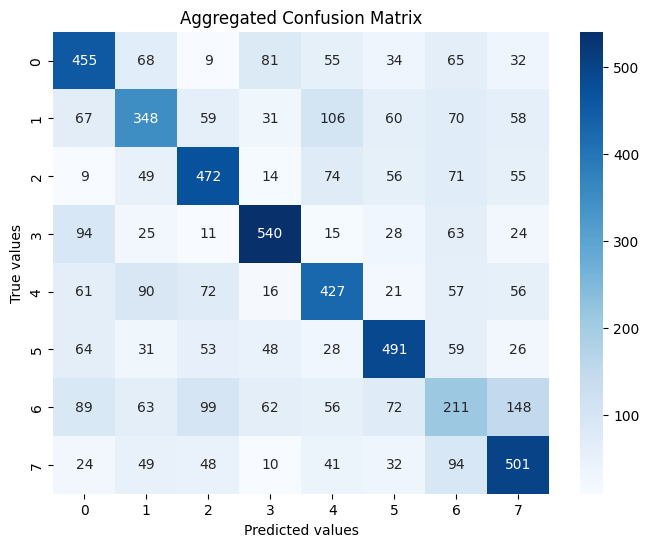

In [22]:
# Plotting the aggregated (over the 4-folds) Confusion Matrix

plt.figure(figsize = (8,6))
sns.heatmap(global_confusion_matrix, annot = True, fmt = "d", cmap = "Blues")
plt.title("Aggregated Confusion Matrix")
plt.xlabel("Predicted values")
plt.ylabel("True values")
plt.show()

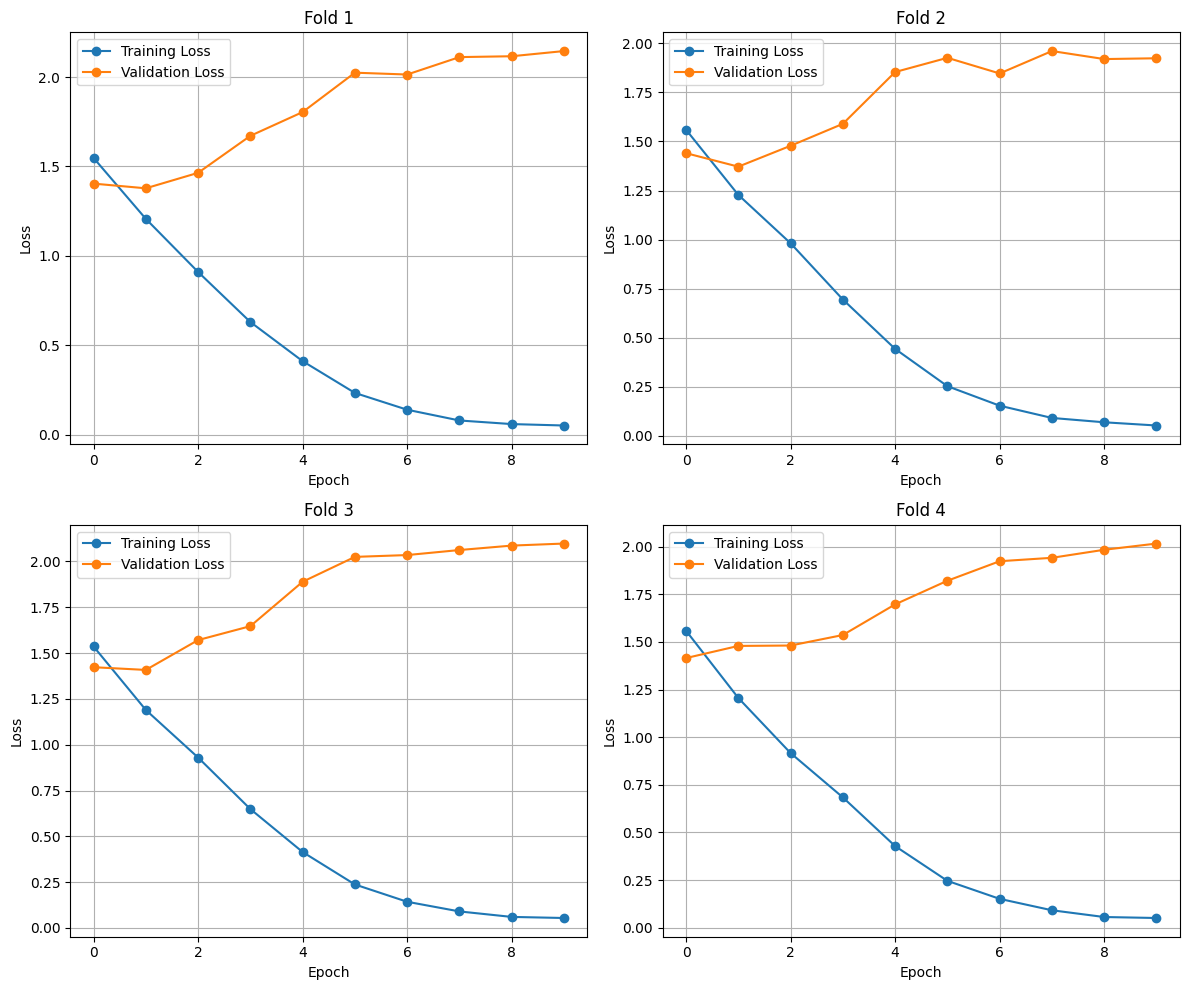

In [23]:
# Plotting the Learning Curves "Training Loss vs Validation Loss" for every epoch in every fold

# Layout settings
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
axes = axes.flatten()

for i, h in enumerate(histories):
    ax = axes[i]
    ax.plot(h["train_loss"], label = "Training Loss", marker = "o")
    ax.plot(h["valid_loss"], label = "Validation Loss", marker = "o")
    ax.set_title(f"Fold {i+1}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

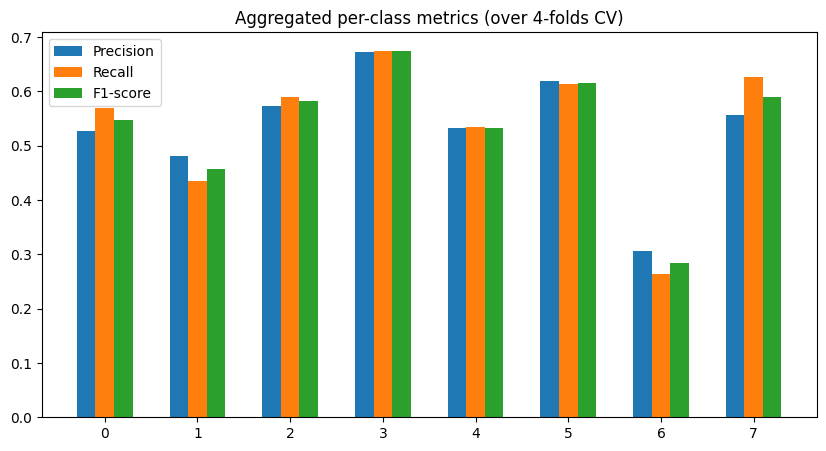

In [24]:
# Plotting the aggregated per-class metrics (precision, recall, f1-score)

# Instead of considering the value computed in every fold for these three metrics,
# the latter are computed confronting all predictions and labels (6397*4)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_predictions, average = None, labels = np.arange(num_classes))

plt.figure(figsize = (10,5))
plt.bar(np.arange(num_classes) - 0.2, precision, width = 0.2, label = "Precision")
plt.bar(np.arange(num_classes), recall, width = 0.2, label = "Recall")
plt.bar(np.arange(num_classes) + 0.2, f1, width = 0.2, label = "F1-score")
plt.xticks(np.arange(num_classes))
plt.legend()
plt.title("Aggregated per-class metrics (over 4-folds CV)")
plt.show()

In [26]:
# After training and evaluating the model on 80% of the data through Cross-Validation, this portion of the dataset
# will be used one last time, in its entirety, to train the model (its "optimized version"). The metrics of the model
# will be then computed on the test set (the remaining 20% of the data) as final evaluation

final_epochs = 10

# 1. Preparing the two sets and initializing the model

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size = 128, shuffle = True, num_workers = 2, pin_memory = True)

model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)

for param in model.parameters():
  param.requires_grad = False

for idx, block in enumerate(model.features[4:]):
      for param in block.parameters():
        param.requires_grad = True

for param in model.classifier.parameters():
  param.requires_grad = True

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

model = model.to(device)

# Define the Loss function and the Optimization algorithm
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = 1e-3, weight_decay = 1e-6)
scheduler = CosineAnnealingLR(optimizer, T_max = final_epochs)

scaler = torch.amp.GradScaler('cuda') # for a more efficient execution

# 2. Training and evaluating the model one last time

all_losses = []

for epoch in range(final_epochs):

    epoch_loss = {"train_loss": [], "test_loss": []}
    train_loss = 0.0
    test_loss = 0.0

    # Training

    model.train()

    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    train_loss_epoch = train_loss / len(train_loader)
    epoch_loss["train_loss"] = train_loss_epoch

    # Evaluation

    model.eval()

    with torch.no_grad():

        for images, labels in test_loader:

          images, labels = images.to(device), labels.to(device)
          outputs = model(images)

          loss = criterion(outputs, labels)
          test_loss += loss.item()

    test_loss_epoch = test_loss / len(test_loader)
    epoch_loss["test_loss"] = test_loss_epoch

    all_losses.append(epoch_loss)

    scheduler.step()

print("✅ Final Training and Evaluation completed")

✅ Final Training and Evaluation completed


In [27]:
# Computing the final Accuracy on the Test set

model.eval()

correct = 0
total = len(test_dataset)

with torch.no_grad():

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        correct += (preds == labels).sum().item()

print(f"Accuracy on the Test set: {correct / total:.4f}")

Accuracy on the Test set: 0.5881


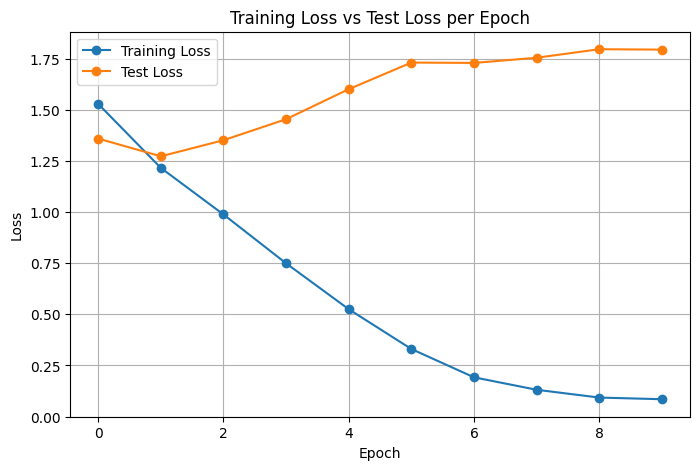

In [28]:
# Plotting the Learning Curve "Training Loss vs Validation Loss" for every epoch

# Extracting the necessary values
train_losses = [x["train_loss"] for x in all_losses]
test_losses = [x["test_loss"] for x in all_losses]

# Plotting the results
plt.figure(figsize = (8,5))
plt.plot(train_losses, label = "Training Loss", marker = 'o')
plt.plot(test_losses, label = "Test Loss", marker = 'o')
plt.title("Training Loss vs Test Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()